# Teste 1 - Python

        Tentando importar e utilizar os dados do Ministério da Saúde em https://covid.saude.org.br para avaliar a situação divulgada oficialmente pelo MS; 
        A url muda diariamente... como puxar o arquivo csv automaticamente?

## Gráficos dos Dados

        Mostrar infectados e mortes confirmados diariamente
        Mostrar infectados e mortes confirmados acumulados
        Mostrar dados separados por região e por estado

## Estimativas (Regressão)
        
        Estimar próximos números (até 7 dias?) utilizando 2, 3 ou 4 (todos?) dias anteriores e regressão não linear
        
## Modelo de Contágio

        Utilizar dados adquiridos para rodar um modelo epidemiológico que utiliza valores de reprodução base e evolução da COVID-19, causada pelo vírus SARS-COV-2

In [230]:
import pandas as pd
import numpy as np
from datetime import datetime,timedelta
from sklearn.metrics import mean_squared_error
from scipy.optimize import curve_fit
from scipy.optimize import fsolve
import matplotlib.pyplot as plt
%matplotlib inline

url = "https://mobileapps.saude.gov.br/esus-vepi/files/unAFkcaNDeXajurGB7LChj8SgQYS2ptm/c78c65835dc96d32b3ca39709200b0cc_Download_COVID19_20200421.csv"

In [231]:
df = pd.read_csv(url, sep = ";")

df

,regiao,estado,data,casosNovos,casosAcumulados,obitosNovos,obitosAcumulados
0,Norte,RO,30/01/2020,0,0,0,0
1,Norte,RO,31/01/2020,0,0,0,0
2,Norte,RO,01/02/2020,0,0,0,0
3,Norte,RO,02/02/2020,0,0,0,0
4,Norte,RO,03/02/2020,0,0,0,0
5,Norte,RO,04/02/2020,0,0,0,0
6,Norte,RO,05/02/2020,0,0,0,0
7,Norte,RO,06/02/2020,0,0,0,0
8,Norte,RO,07/02/2020,0,0,0,0
9,Norte,RO,08/02/2020,0,0,0,0


In [232]:
df = pd.read_csv(url, sep = ";")

df1 = df.loc[:, ['data', 'casosAcumulados', 'casosNovos', 'obitosAcumulados', 'obitosNovos']]

df_UF = df.loc[:, ["estado", 'data', 'casosAcumulados', 'casosNovos', 'obitosAcumulados', 'obitosNovos']]

FMT = '%d/%m/%Y'

date = df['data']

df1['data'] = date.map(lambda x : (datetime.strptime(x, FMT) - datetime.strptime("30/01/2020", FMT)).days)
df_UF['data'] = date.map(lambda x : (datetime.strptime(x, FMT) - datetime.strptime("30/01/2020", FMT)).days)

df_UF

,estado,data,casosAcumulados,casosNovos,obitosAcumulados,obitosNovos
0,RO,0,0,0,0,0
1,RO,1,0,0,0,0
2,RO,2,0,0,0,0
3,RO,3,0,0,0,0
4,RO,4,0,0,0,0
5,RO,5,0,0,0,0
6,RO,6,0,0,0,0
7,RO,7,0,0,0,0
8,RO,8,0,0,0,0
9,RO,9,0,0,0,0


In [233]:
df1 = df1.groupby("data").sum()

# total of days since 2020-01-30 - x
x = list(df1.index)

# total cases - y
y = list(df1.iloc[:, 0])

# new cases - y
y_n = list(df1.iloc[:, 1])

# total deaths - y
y_d = list(df1.iloc[:, 2])

# new deaths - y
y_dn = list(df1.iloc[:, 3])


In [234]:
# logistic model of the evolution of the contamination in Brazil

def logistic_model (x, a, b, c) :
    return c/ (1 + np.exp ( - (x - b) / a))

# curve_fit(f, xdata, ydata, p0=None, sigma=None, absolute_sigma=False, check_finite=True, bounds=(-inf, inf), method=None, jac=None, **kwargs)[source]

# total cases
logistic_fit = curve_fit(logistic_model, x, y, p0 = [2, 100, 20000])

l_a = logistic_fit[0][0]
l_b = logistic_fit[0][1]
l_c = logistic_fit[0][2]

# new cases
new_logistic_fit = curve_fit(logistic_model, x, y_n, p0 = [2, 100, 20000])

l_a_n = new_logistic_fit[0][0]
l_b_n = new_logistic_fit[0][1]
l_c_n = new_logistic_fit[0][2]

# total deaths
death_logistic_fit = curve_fit(logistic_model, x, y_d, p0 = [2, 10, 200])

l_a_d = death_logistic_fit[0][0]
l_b_d = death_logistic_fit[0][1]
l_c_d = death_logistic_fit[0][2]

# new deaths
new_death_logistic_fit = curve_fit(logistic_model, x, y_dn, p0 = [2, 10, 200])

l_a_dn = new_death_logistic_fit[0][0]
l_b_dn = new_death_logistic_fit[0][1]
l_c_dn = new_death_logistic_fit[0][2]

# errors evaluation
logistic_errors = [np.sqrt(logistic_fit[1][i][i]) for i in [0, 1, 2]]

logistic_sol = int(fsolve(lambda x : logistic_model(x, l_a, l_b, l_c) - int(l_c), l_b))
new_logistic_sol = int(fsolve(lambda x : logistic_model(x, l_a_n, l_b_n, l_c_n) - int(l_c_n), l_b_n))
death_logistic_sol = int(fsolve(lambda x : logistic_model(x, l_a_d, l_b_d, l_c_d) - int(l_c_d), l_b_d))
new_death_logistic_sol = int(fsolve(lambda x : logistic_model(x, l_a_dn, l_b_dn, l_c_dn) - int(l_c_dn), l_b_dn))

In [235]:
def exponential_model (x, a, b, c) :
    return a * np.exp (b * (x - c))

#curve_fit(f, xdata, ydata, p0=None, sigma=None, absolute_sigma=False, check_finite=True, bounds=(-inf, inf), method=None, jac=None, **kwargs)[source]

# total cases
exponential_fit = curve_fit(exponential_model, x, y, p0 = [1, 1, 1], bounds = (0, df.index.size))

e_a = exponential_fit[0][0]
e_b = exponential_fit[0][1]
e_c = exponential_fit[0][2]

# new cases
new_exponential_fit = curve_fit(exponential_model, x, y_n, p0 = [1, 1, 1], bounds = (0, df.index.size))

e_a_n = new_exponential_fit[0][0]
e_b_n = new_exponential_fit[0][1]
e_c_n = new_exponential_fit[0][2]

# total deaths
death_exponential_fit = curve_fit(exponential_model, x, y_d, p0 = [1, 1, 1], bounds = (0, df.index.size))

e_a_d = death_logistic_fit[0][0]
e_b_d = death_logistic_fit[0][1]
e_c_d = death_logistic_fit[0][2]

# new deaths
new_death_exponential_fit = curve_fit(exponential_model, x, y_dn, p0 = [1, 1, 1], bounds = (0, df.index.size))

e_a_dn = new_death_logistic_fit[0][0]
e_b_dn = new_death_logistic_fit[0][1]
e_c_dn = new_death_logistic_fit[0][2]

# errors evaluation
exponential_errors = [np.sqrt(exponential_fit[1][i][i]) for i in [0, 1, 2]]

exponential_sol = int(fsolve(lambda x : exponential_model(x, e_a, e_b, e_c) - int(e_c), e_b))
new_exponential_sol = int(fsolve(lambda x : exponential_model(x, e_a_n, e_b_n, e_c_n) - int(e_c_n), e_b_n))
exponential_sol = int(fsolve(lambda x : exponential_model(x, e_a_d, e_b_d, e_c_d) - int(e_c_d), e_b_d))
new_exponential_sol = int(fsolve(lambda x : exponential_model(x, e_a_dn, e_b_dn, e_c_dn) - int(e_c_dn), e_b_dn))

/srv/conda/envs/notebook/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: overflow encountered in exp
  


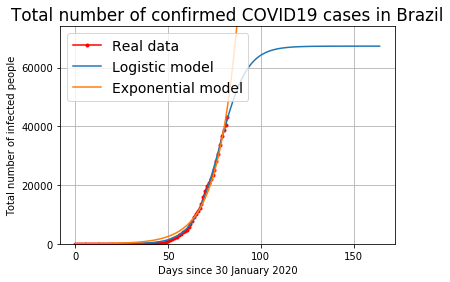

332

In [236]:
plt.grid(True)
plt.rc('font', size=14)
plt.rcParams['figure.figsize'] = [14, 7]

pred_x = list(range(max(x), logistic_sol))

# Real data
plt.plot(x, y, marker = '.', label = "Real data", color="red")

# Predicted logistic curve
plt.plot(x + pred_x, [logistic_model(i, logistic_fit[0][0], logistic_fit[0][1], logistic_fit[0][2]) for i in x + pred_x], label = "Logistic model" )

# Predicted exponential curve
plt.plot(x + pred_x, [exponential_model(i, exponential_fit[0][0], exponential_fit[0][1], exponential_fit[0][2]) for i in x + pred_x], label = "Exponential model" )

plt.title("Total number of confirmed COVID19 cases in Brazil")
plt.legend()
plt.xlabel("Days since 30 January 2020")
plt.ylabel("Total number of infected people")
plt.ylim(0, l_c * 1.1)
plt.show()
df1.size

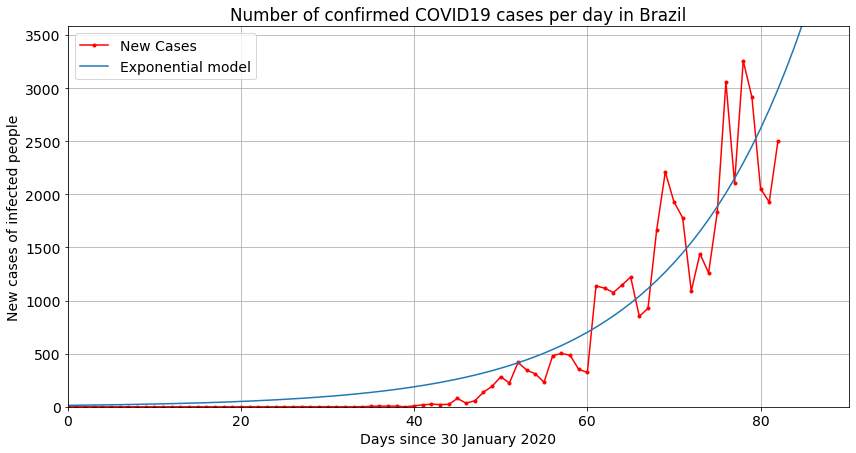

In [237]:
plt.grid(True)
plt.rc('font', size=14)
plt.rcParams['figure.figsize'] = [14, 7]

pred_x = list(range(max(x), new_logistic_sol))

plt.plot(x, y1, marker = '.', label = "New Cases", color="red")

# Predicted exponential curve
plt.plot(x+pred_x, [exponential_model(i, new_exponential_fit[0][0], new_exponential_fit[0][1], new_exponential_fit[0][2]) for i in x + pred_x], label = "Exponential model" )

plt.title("Number of confirmed COVID19 cases per day in Brazil")
plt.legend()
plt.xlabel("Days since 30 January 2020")
plt.ylabel("New cases of infected people")
plt.ylim(0, max(y_n) * 1.1)
plt.xlim(0, max(x) * 1.1)
plt.show()

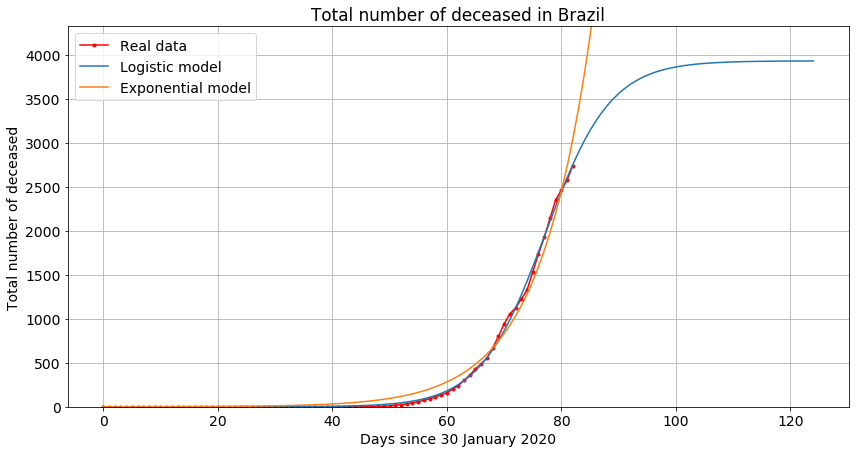

In [238]:
plt.grid(True)
plt.rc('font', size=14)
plt.rcParams['figure.figsize'] = [14, 7]

pred_x = list(range(max(x), death_logistic_sol))

# Real data
plt.plot(x, y_d, marker = '.', label = "Real data", color="red")

# Predicted logistic curve
plt.plot(x + pred_x, [logistic_model(i, death_logistic_fit[0][0], death_logistic_fit[0][1], death_logistic_fit[0][2]) for i in x + pred_x], label = "Logistic model" )

# Predicted exponential curve
plt.plot(x + pred_x, [exponential_model(i, death_exponential_fit[0][0], death_exponential_fit[0][1], death_exponential_fit[0][2]) for i in x + pred_x], label = "Exponential model" )

plt.title("Total number of deceased in Brazil")
plt.legend()
plt.xlabel("Days since 30 January 2020")
plt.ylabel("Total number of deceased")
plt.ylim(0, l_c_d * 1.1)
plt.show()

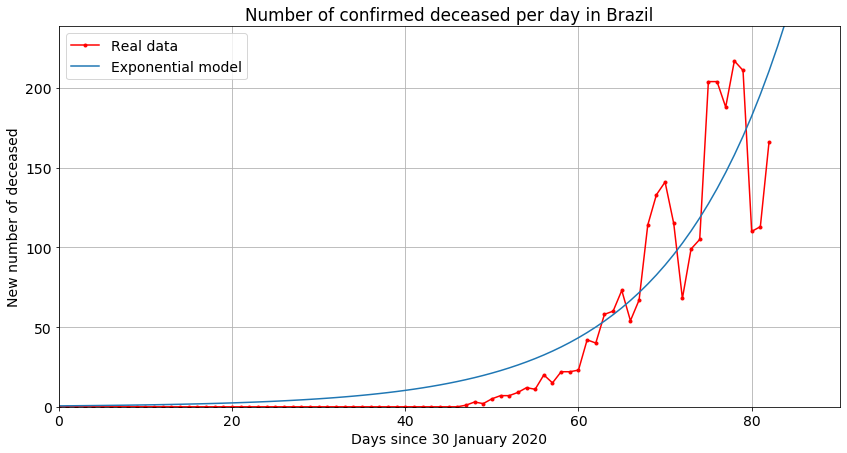

In [239]:
plt.grid(True)
plt.rc('font', size=14)
plt.rcParams['figure.figsize'] = [14, 7]

pred_x = list(range(max(x), death_logistic_sol))

# Real data
plt.plot(x, y_dn, marker = '.', label = "Real data", color="red")

# Predicted exponential curve
plt.plot(x + pred_x, [exponential_model(i, new_death_exponential_fit[0][0], new_death_exponential_fit[0][1], new_death_exponential_fit[0][2]) for i in x + pred_x], label = "Exponential model" )

plt.title("Number of confirmed deceased per day in Brazil")
plt.legend()
plt.xlabel("Days since 30 January 2020")
plt.ylabel("New number of deceased")
plt.xlim(0, max(x) * 1.1)
plt.ylim(0, max(y_dn) * 1.1)
plt.show()

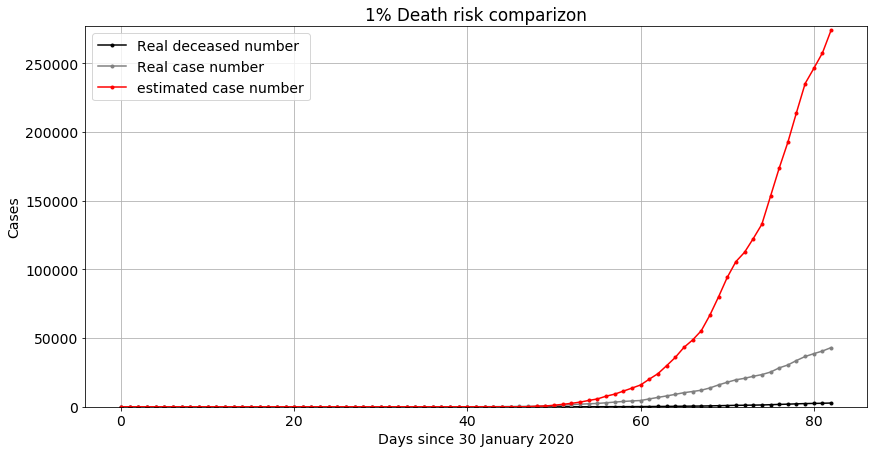

In [240]:
plt.grid(True)
plt.rc('font', size=14)
plt.rcParams['figure.figsize'] = [14, 7]

# Real data
plt.plot(x, y_d, marker = '.', label = "Real deceased number", color = "black")
plt.plot(x, y, marker = '.', label = "Real case number", color = "gray")

y_d1 = list(df1.iloc[:, 2].multiply(100))

plt.plot(x, y_d1, marker = '.', label = "estimated case number", color = "red")

plt.title("1% Death risk comparizon")
plt.legend()
plt.xlabel("Days since 30 January 2020")
plt.ylabel("Cases")
plt.ylim(0, max(y_d) * 101)
plt.show()

In [250]:
df_SP = df_UF.loc[df_UF.iloc[:,0] == 'SP', :].iloc[:, [1, 2]]

df_SP

,data,casosAcumulados
1577,0,0
1578,1,0
1579,2,0
1580,3,0
1581,4,0
1582,5,0
1583,6,0
1584,7,0
1585,8,0
1586,9,0
